# Template for hand-in on private clustering

Advanced Topics in Machine Learning, U. Copenhagen, fall 2023

Created by Rasmus Pagh

# Fetch and load dataset

The dataset consists of 3414 embedding vectors for first names from the GloVe dataset. Each vector is a 100-dimensional unit vector.

In [23]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

!curl -s https://rasmuspagh.net/data/glove.twitter.27B.100d.names.pickle -O
input_file = "glove.twitter.27B.100d.names.pickle"
with open(input_file, 'rb') as f:
    embedding = pickle.load(f)
names = list(embedding.keys())
points = np.array([ embedding[x] for x in names ])
n, d = points.shape

# Non-private implementation of cost computation and k-means algorithm

In [24]:
def compute_cost(points, centers):
    distances_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
    return np.mean(np.min(distances_squared, axis=0))


def k_means(points, k, t):
    initial_assignment = np.random.choice(range(k), n)
    cluster_indexes = [ (initial_assignment == i) for i in range(k) ]
    cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    for l in range(t):
        cluster_sums = [ np.sum(points[cluster_indexes[i]], axis=0) for i in range(k) ]
        centers = np.array([ cluster_sums[i] / max(1, cluster_sizes[i]) for i in range(k) ])
        distances_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
        assignment = np.argmin(distances_squared, axis=0)
        cluster_indexes = [ (assignment == i) for i in range(k)]
        cluster_sizes = [ cluster_indexes[i].sum() for i in range(k)]

    return centers

# Plot cost as function of number of iterations

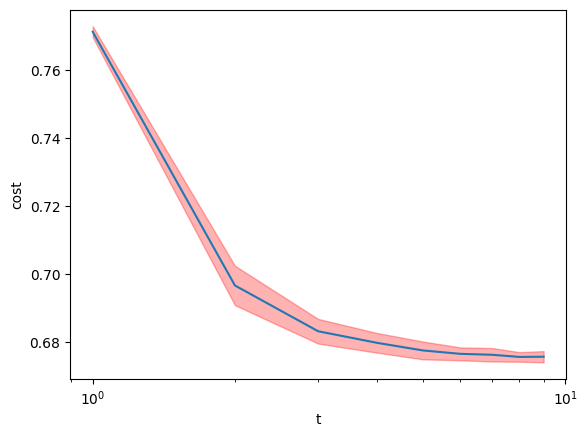

In [25]:
cost_collection = []
for i in range(100):
    k = 5 # Number of clusters
    t_range = range(1,10)
    costs = []
    for t in t_range: # number of iterations
        centers = k_means(points, k, t)
        costs.append(compute_cost(points, centers))
    cost_collection.append(costs)

# Get 
mus = np.mean(cost_collection, axis = 0)
sd = np.std(cost_collection, axis = 0)
fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('cost')
ax.plot(t_range, mus)
ax.fill_between(t_range, mus - sd, mus + sd, color = "r", alpha = 0.3)
plt.xscale('log')
plt.show()


In [26]:
def M_means(points, k, t, rho): 
    
    sigma = np.sqrt((4 * t) / rho)
    sigma_prime = np.sqrt((2 * t) / rho)

    # Initialization: 
    initial_assignment = np.random.choice(range(k), n)
    cluster_indexes = np.array([(initial_assignment == i) for i in range(k)])
    cluster_sizes = np.array([cluster_indexes[i].sum() for i in range(k)])
    centers = np.zeros((k, d))

    for _ in range(t): 

        # a) Update i'th cluster center: 
        for i in range(k): 
            z_i = np.random.normal(loc=0, scale=sigma, size=d)
            cluster_sum = np.sum(points[cluster_indexes[i]], axis=0) + z_i
            centers[i] = cluster_sum / max(1, cluster_sizes[i])
        
        # b) Update assignment of closest xs:
        norms_squared = np.sum((points - centers[:,np.newaxis])**2, axis=-1)
        assignment = np.argmin(norms_squared, axis=0)
        cluster_indexes = np.array([(assignment == i) for i in range(k)])
        cluster_sizes = np.array([cluster_indexes[i].sum() for i in range(k)])

        # c) 
        cluster_sizes = cluster_sizes + np.random.normal(loc=0, scale=sigma_prime, size=k)

    return centers, cluster_indexes


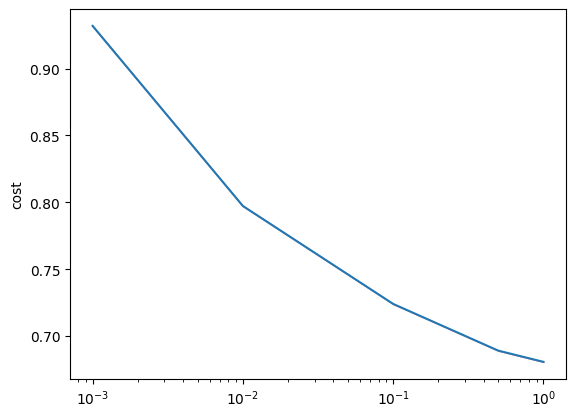

In [27]:
# running the experiment 100 times:
cost_collection = []
rho_range = [0.001, 0.01, 0.1, 0.5, 1]
for i in range(100):
    costs = []
    for rho in rho_range:
        centers , _ = M_means(points=points, k=5, t=5, rho=rho)
        costs.append(compute_cost(points, centers))
cost_collection.append(costs)

# Plotting: 
mus = np.mean(cost_collection, axis = 0)
sd = np.std(cost_collection, axis = 0)
fig, ax = plt.subplots()
ax.set_xlabel('')
ax.set_ylabel('cost')
ax.plot(rho_range, mus)
ax.fill_between(rho_range, mus - sd, mus + sd, color = "r", alpha = 0.3)
plt.xscale('log')
plt.show()
